# LLM Agents to Answer Complex Questions on Structured and Unstructured Data

This notebook shows how to create a simple `plan-and-execute` style agent to retrieve infromation from structured (SQL DB) and unstructured dataset (pdf documents). The system described below allow you to simply chat with a bot and get general informations directly from ChatGPT and execute complex request where planning and careful execution is required.  



<div style="text-align: center;">
<img src="images/structured_unstructured.png" alt="Example Image" width="800"/>
</div>

This is similar to a typical [ReAct](https://arxiv.org/abs/2210.03629) style agent where you think one step at a time. The advantages of this `plan-and-execute`
style agent are:

1. Explicit long term planning (which existing LLMs can struggle with)
2. Ability to use smaller/weaker models for the execution step, only using larger models for the planning step


The framework proposed here is organized as follows:

1. The user submits a request to the `Orchestrator`. The request can be a simple questions (e.g., 'What is the capital of Spain?') or a request that requires careful planning and execution to answer.
2. If the users determins that the request requires planning, it sents the request to the `Planner`.
3. The `Planner` breaks down the request into a list of actionable tasks
4. Each task is then executed using a list of available `Tools`, which allow our agent to commnicate with the outside world and retrieve the necessary information to complete the task. The outside world may include the web, a repository of documents, a large collection of images, or any other structured or unstructured source of information and data.
5. `Tools` here refer to various mechanisms and functions that enable our agent to access the nessecary information, such as APIs, Retrieval-Augmented Generation (RAG) systems and etc. 
6. Once all the tasks are executed, the final output is sent to `Replan`, which evaluates whether the result meets the requirements of the original request.
7. If the answer is not satisfactory, `Replan` will refine the task list and generate a new execution plan. This process may iterate multiple times until an appropriate answer is obtained.
8. Once `Replan` determines that the final answer is sufficient, it is communicated back to the user.

In [16]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import create_react_agent
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.messages import HumanMessage
from langgraph.graph import END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing import Dict
from config import Settings
import os
import re

from pydantic import BaseModel, Field
import sqlite3
import operator
from typing import Annotated, List, Tuple, Union
from typing_extensions import TypedDict

In [3]:
api_key = Settings.api_key
VECTOR_DIR = 'vectorize'
embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002",
    api_key=api_key)

### Run the bellow cell if you haven't created the embeddings

In [41]:
#file_paths = ["data/nvidia_10k_21.pdf", "data/lyft_10k_21.pdf"]

#for file_path in file_paths:
#    loader = PyPDFLoader(file_path)
#    document = loader.load()
#    company_name = file_path.split("/")[1].split("_")[0]
#    print("Company: ", company_name)
#    save_dir = VECTOR_DIR + "/" + company_name
#    if not os.path.exists(save_dir):
#        os.makedirs(save_dir)
#    vector_store = FAISS.from_documents(document, embeddings)
#    vector_store.save_local(save_dir)

In [4]:
llm = ChatOpenAI(model="gpt-4o", api_key=api_key)

SYSTEM_TEMPLATE = """
    Answer the user's questions based on the below context. 
    If the context doesn't contain any relevant information to the questions, don't make someting up
    and just reply information cannot be fount:
    <context>
    {context}
    </context>
    """

sql_prompt = """You are an SQL expert coder and you need to convert user queries into relevant SQL code in order
                to retrieve the required information from a structured SQLite database. \n

                Below are the columns from the table called fundamentals in the sqlite database along with their description \n:

                date - The date which the company (Ticker) earnings where reported \n
                ticker - The ticker of the company in question. The tickers are always in lowercase strings such as nvda, vz \n
                price - The price of the stock for the particular ticker the specified date \n
                sp500 - The S&P 500 index price for the specified date \n
                market_cap - The market cap of the company \n
                enterprice_value - The enterprice value of the company \n
                trailing_pe - The trailing P/E ratio \n
                forward_pe - The forward P/E ratio \n
                peg_ratio - The PEG Ratio \n
                price_sales - It is the financial evaluation metric that compares a company's market cap (or stock price) to its total revenue \n
                price_book - This is the price to book ratio. It compares a company's market price per share to its book value per share (BVPS) \n
                enterprice_value_revenue - is a ratio that compares a company's total enterprice value (EV) to its revenue \n
                quarter - the quarter and the year which the financial data were reported. For example, 2012Q4
                """

In [20]:
def texttosqlQA(statsquestions: str) -> str:
    """
    It allows users to answer questions related to historical financial fundamentals from s&p 500 companies.
    For example, it allows you to retrieve information ragarding the price in a particular quarter, market cap,
    enterprise value, P/E and etc.

    Parameters:
    -statsquestions: the question we need to answer from the historical financial fundamentals of the s&p 500 companies

    Returns:
    - A string with the right answer
    """

    messages = [
        {"role": "system", "content": sql_prompt},
        {"role": "user", "content": statsquestions}
    ]

    response = llm(messages)
    output = response.content
    pattern = r"```sql\n(.*?)\n```"
    match = re.search(pattern, output, re.DOTALL)
    if match:
        sql_code = match.group(1)
        print(sql_code)
        conn = sqlite3.connect("sp500_financials_database.db")
        cursor = conn.cursor()
        cursor.execute(sql_code)
        results = cursor.fetchall()
        return results
    else:
        return "No SQL code found"


def parse_retriever_input(params: Dict):
    return params["messages"][-1].content

def contextualQA(earnings_question: str, company_name: str) -> str:

    """
    Identifies the relevant context in the earning call transcripts to the user question

    This tool searches in the earnings calls transcript documents and extract financial information
    such as net income, REvenue, EBITDA and etc.

    Parameters:
    - earnings_question: The questions asked by the user
    - company_name: the company for which we need to answer the question. Company names should always be lowercase

    Returns:
    - A string with the context that contain the answer to the earnings question.
    """
    vector_store = FAISS.load_local(VECTOR_DIR + "/" + company_name, 
                                    embeddings, 
                                    allow_dangerous_deserialization=True)
    retriever = vector_store.as_retriever()
    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM_TEMPLATE),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    qa_chain = create_stuff_documents_chain(llm, qa_prompt)
    retrieval_chain = RunnablePassthrough.assign(
    context = parse_retriever_input | retriever).assign(answer=qa_chain)
    response = retrieval_chain.invoke(
        {
            "messages": [HumanMessage(content=earnings_question)]
        }
    )
    return response["answer"]


In [21]:
texttosqlQA("what was the price of vz at the 4th quarter of 2012?")

SELECT price 
FROM fundamentals 
WHERE ticker = 'vz' 
  AND quarter = '2012Q4';


[(24.519493103027344,)]

In [23]:
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str



class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

class Objective(BaseModel):
    """The current objective of the user"""
    input: str = Field(
        description="The current objective of the user - it should contain clear instructions for the planner"
    )


class Response(BaseModel):
    """Response to user"""
    response: str

class Act(BaseModel):
    """Action to perform"""
    action: Union[Response, Plan] = Field(
        description = """Action to perform. If you want to respond to the user, use Response. If you need to further use
         tools to get the answer, use Plan."""
    )

class ActGovernor(BaseModel):
    action: Union[Response, Objective] = Field(
        description=(
            "The 'action' field must contain either a 'Response' or 'Objective' object"
            "Use a 'Response' object when you want to directly respond to the user with a message."
            "Use an 'Objective' object when the request needs to be sent to the planner for further processing. "
            "The 'Objective' object should clearly define the user's goal or task. "
            "Ensure that the 'action' field is always populated with one of these objects to maintain consistency"
        )
    )



In [24]:
tools = [contextualQA, texttosqlQA]

prompt = """You are a helpful assistant that have access to powerful tools: \n

            texttosqlQA: A tool that allows users to answer questions related to historical financial fundamentals from s&p 500 companies.
            For example, it allows you to retrieve information ragarding the price in a particular quarter, market cap,
            enterprise value, P/E and etc. \n
            
            Parameters:\n
            -statsquestions: the question we need to answer from the historical financial fundamentals of the s&p 500 companies \n
            
            Returns: \n
            - A string with the right answer

            contextualQA: A tool to identify the relevant context in the earning call transcripts to the user question.
            This tool searches in the earnings calls transcript documents and extract financial information
            such as net income, REvenue, EBITDA and etc. \n
            
            Parameters:\n
            - earnings_question: The questions asked by the user \n
            - company_name: the company for which we need to answer the question. Company names should always be lowercase \n
            
            Returns: \n
            - A string with the context that contain the answer to the earnings question.
            """

agent_executor = create_react_agent(llm, tools, prompt=prompt)


planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \n
            This plan should involve individual tasks, that if executed correctly will yield the correct answer. 
            Do not add any superfluous steps. The result of the final step should be the final answer. \n
            Make sure that each step has all the information needed - do not skip steps.\n
            
            The individual in the plan should only include the following tools: \n

             texttosqlQA: A tool that allows users to answer questions related to historical financial fundamentals from s&p 500 companies.
                 For example, it allows you to retrieve information ragarding the price in a particular quarter, market cap,
                 enterprise value, P/E and etc. \n
                 
                 Parameters:\n
                 -statsquestions: the question we need to answer from the historical financial fundamentals of the s&p 500 companies \n
                 
                 Returns: \n
                 - A string with the right answer

            contextualQA: A tool to identify the relevant context in the earning call transcripts to the user question.
                This tool searches in the earnings calls transcript documents and extract financial information 
                such as net income, REvenue, EBITDA and etc. \n
                
                Parameters:\n
                - earnings_question: The questions asked by the user \n
                - company_name: the company for which we need to answer the question. Company names should always be lowercase \n
            
            Returns: \n
            - A string with the context that contain the answer to the earnings question.
            """,
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(Plan)

replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan.
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
    Your objective was this:
    {input}
    
    Your original plan was this:
    {plan}
    
    You have currently done the follow steps:
    {past_steps}
    
    Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(Act)

governor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system", """You can either send the request to the planner or respond to the user directly. 
            Send the request to the planner if the user's question can be fully or partially solved by the planner.\n
            The Planner is an agent equiped with several powerful tools designed to help users retrieve information from 
            structured data such as SQLite DB and unstructured dataset such as pdfs.\n

            The planner has access has access to the following set of tools: \n

            texttosqlQA: A tool that allows users to answer questions related to historical financial fundamentals from s&p 500 companies.
            For example, it allows you to retrieve information ragarding the price in a particular quarter, market cap,
            enterprise value, P/E and etc. \n
            
            Parameters:\n
            -statsquestions: the question we need to answer from the historical financial fundamentals of the s&p 500 companies \n
            
            Returns: \n
            - A string with the right answer

            contextualQA: A tool to identify the relevant context in the earning call transcripts to the user question.
            This tool searches in the earnings calls transcript documents and extract financial information
            such as net income, REvenue, EBITDA and etc. \n
            
            Parameters:\n
            - earnings_question: The questions asked by the user \n
            - company_name: the company for which we need to answer the question. Company names should always be lowercase \n
            
            Returns: \n
            - A string with the context that contain the answer to the earnings question.

            
            You must:
            1. Clearly identify the user's objective and take into account all the provided information.
            2. If planning is required, provide the instructions in a structured format so that the planner can easily interpret 
            and execute \n.
            Please skip planning and respond to user directly if any of the following is true: \n
            If the user's question can be answered from the context of the overall discussion; \n
            If the user's query doesn't require planning and using the tools provided \n
            If the user simply wants to chat; \n
            If the user's query is vague, ambiguous or unclear and would like clarifications;
            """
        ),
        ("user", "Current message: {input}")
    ]
)

info_model_prompt = [
    ('system',
    """You are a Data Science agent equipped with powerful tools [contextualQA, texttosqlQA] designed to help the user extract information 
    from earnings calls transcripts documents and from the historical financial fundamentals from the s&p 500 companies""")
]


governor = governor_prompt | llm.with_structured_output(ActGovernor, method="function_calling")

In [25]:
async def info_model(state: PlanExecute) -> PlanExecute:
    """
    Calls the model with the given state and returns the updated state.
    Args:
       state (PlanExecute): The current state of teh plan execution.

    Returns:
       PlanExecute: The updated state after calling the model
    """
    response = state_response
    formatted_response = info_model_prompt
    formatted_response += [
        {
            "role": "assistant",
            "content": f"I have drafted the following response to the user: {response}",
        }
    ]
    message = await llm.ainvoke(formatted_response)
    return state

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    if not plan:
        return {"response": "No plan to execute."}

    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def governor_step(state: PlanExecute):
    output = await governor.ainvoke(state)
    if isinstance(output.action, Response):
        return {
            "response": output.action.response,
        }
    else:
        return {
            "response": None,
            "input": output.action.input
        }

async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_plan(state: PlanExecute):
    if "response" in state and state["response"]:
        return "info_model"
    else:
        return "planner"

def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [26]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the governor
workflow.add_node("info_model", info_model)
workflow.add_node("governor", governor_step)
# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "governor")
workflow.add_edge("info_model", END)

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")


workflow.add_conditional_edges(
    "governor",
    should_plan,
    ["planner", "info_model"]
)

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)


# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
memory = MemorySaver()
app = workflow.compile()

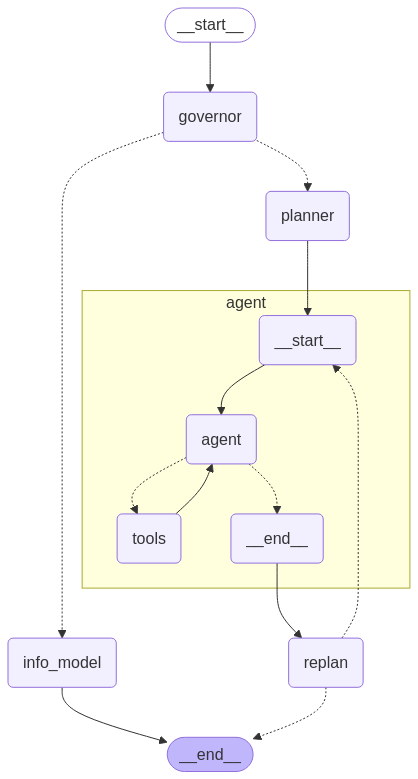

In [27]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [28]:
config = {"configurable": {"thread_id": "3"}}
inputs = {"input": "what was the difference in the total revenue between Nvidia and Lyft in 2020? and what was the price of vz at the forth quarter of 2012?"}

async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(k, v)

governor {'response': None, 'input': '1. Compare the total revenue of Nvidia and Lyft for the year 2020.\n2. Retrieve the stock price of VZ (Verizon) in the fourth quarter of 2012.'}
planner {'plan': ["Use the contextualQA tool with the parameters earnings_question set to 'What was the total revenue for the year 2020?' and company_name set to 'nvidia' to retrieve Nvidia's total revenue for 2020.", "Use the contextualQA tool with the parameters earnings_question set to 'What was the total revenue for the year 2020?' and company_name set to 'lyft' to retrieve Lyft's total revenue for 2020.", 'Compare the total revenue values obtained from steps 1 and 2 to determine which company had higher revenue in 2020.', "Use the texttosqlQA tool with the parameter statsquestions set to 'What was the stock price of VZ in the fourth quarter of 2012?' to retrieve Verizon's stock price in Q4 2012."]}
agent {'past_steps': [("Use the contextualQA tool with the parameters earnings_question set to 'What was